# Cost Functions

## Primitives

In [1]:
from dotenv import load_dotenv
from os import getenv

load_dotenv()
token = getenv('IBM_TOKEN')

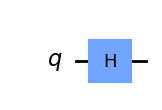

In [5]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

# The following code will work for any other initial single-qubit state and observable
original_circuit = QuantumCircuit(1)
original_circuit.h(0)

H = SparsePauliOp(["X", "Z"], [2, -1])

aux_circuits = []
for pauli in H.paulis:
    aux_circ = original_circuit.copy()
    aux_circ.barrier()
    if str(pauli) == "X":
        aux_circ.h(0)
    elif str(pauli) == "Y":
        aux_circ.sdg(0)
        aux_circ.h(0)
    else:
        aux_circ.id(0)
    aux_circ.measure_all()
    aux_circuits.append(aux_circ)

original_circuit.draw("mpl", style="clifford")

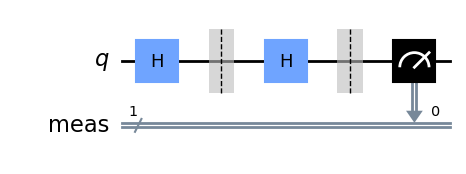

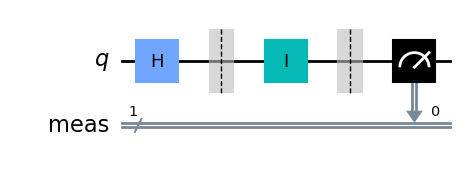

[None, None]

In [8]:
# Auxiliary circuit for X and Z
[display(aux_circuit.draw('mpl', style='clifford')) for aux_circuit in aux_circuits]

In [9]:
from qiskit.primitives import Sampler, Estimator
from qiskit.circuit.library import IGate, ZGate
import numpy as np

## SAMPLER
sampler = Sampler()
job = sampler.run(aux_circuits)
probability_dists = job.result().quasi_dists

expvals = []
for dist, pauli in zip(probability_dists, H.paulis):
    val = 0
    if str(pauli) == "I":
        Lambda = IGate().to_matrix().real
    else:
        Lambda = ZGate().to_matrix().real
    val += Lambda[0][0] * dist.get(0, 0)
    val += Lambda[1][1] * dist.get(1, 0)
    expvals.append(val)

print("Sampler results:")
for (pauli, expval) in zip(H.paulis, expvals):
    print(f"  >> Expected value of {str(pauli)}: {expval:.5f}")

total_expval = np.sum(H.coeffs * expvals).real
print(f"  >> Total expected value: {total_expval:.5f}")

## ESTIMATOR
observables = [
    *H.paulis,
    H,
]  # Note: run for individual Paulis as well as full observable H

estimator = Estimator()
job = estimator.run([original_circuit] * len(observables), observables)
estimator_expvals = job.result().values

print("Estimator results:")
for (obs, expval) in zip(observables, estimator_expvals):
    if obs is not H:
        print(f"  >> Expected value of {str(obs)}: {expval:.5f}")
    else:
        print(f"  >> Total expected value: {expval:.5f}")

Sampler results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000
Estimator results:
  >> Expected value of X: 1.00000
  >> Expected value of Z: 0.00000
  >> Total expected value: 2.00000


## Cost functions

In [10]:
from qiskit.circuit.library import TwoLocal
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session
from qiskit.quantum_info import SparsePauliOp


def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

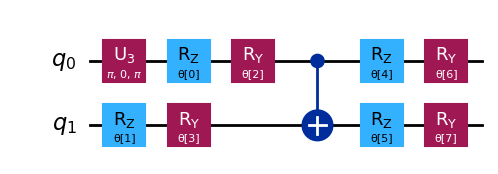

In [13]:
theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()
observable = SparsePauliOp.from_list([("XX", 1), ("YY", -3)])

reference_circuit = QuantumCircuit(2)
reference_circuit.x(0)

variational_form = TwoLocal(
    2,
    rotation_blocks=["rz", "ry"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=1,
)
ansatz = reference_circuit.compose(variational_form)

ansatz.decompose().draw('mpl', style='iqp')

In [15]:
# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum", token=token)
backend = service.backend("ibmq_qasm_simulator")
session = Session(backend=backend)

# Use estimator to get the expected values corresponding to each ansatz
estimator = Estimator(session=session)

theta_list = (2 * np.pi * np.random.rand(1, 8)).tolist()

cost = cost_func_vqe(theta_list, ansatz, observable, estimator)

# Close session after done
session.close()

cost

-0.575

### Example mapping to non-physical systems

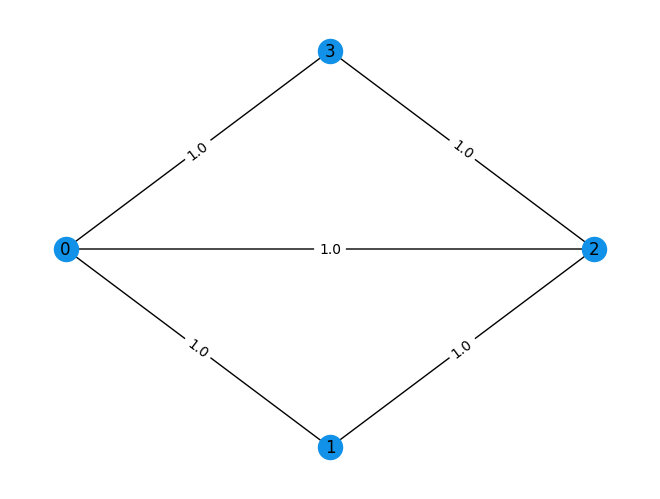

In [16]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

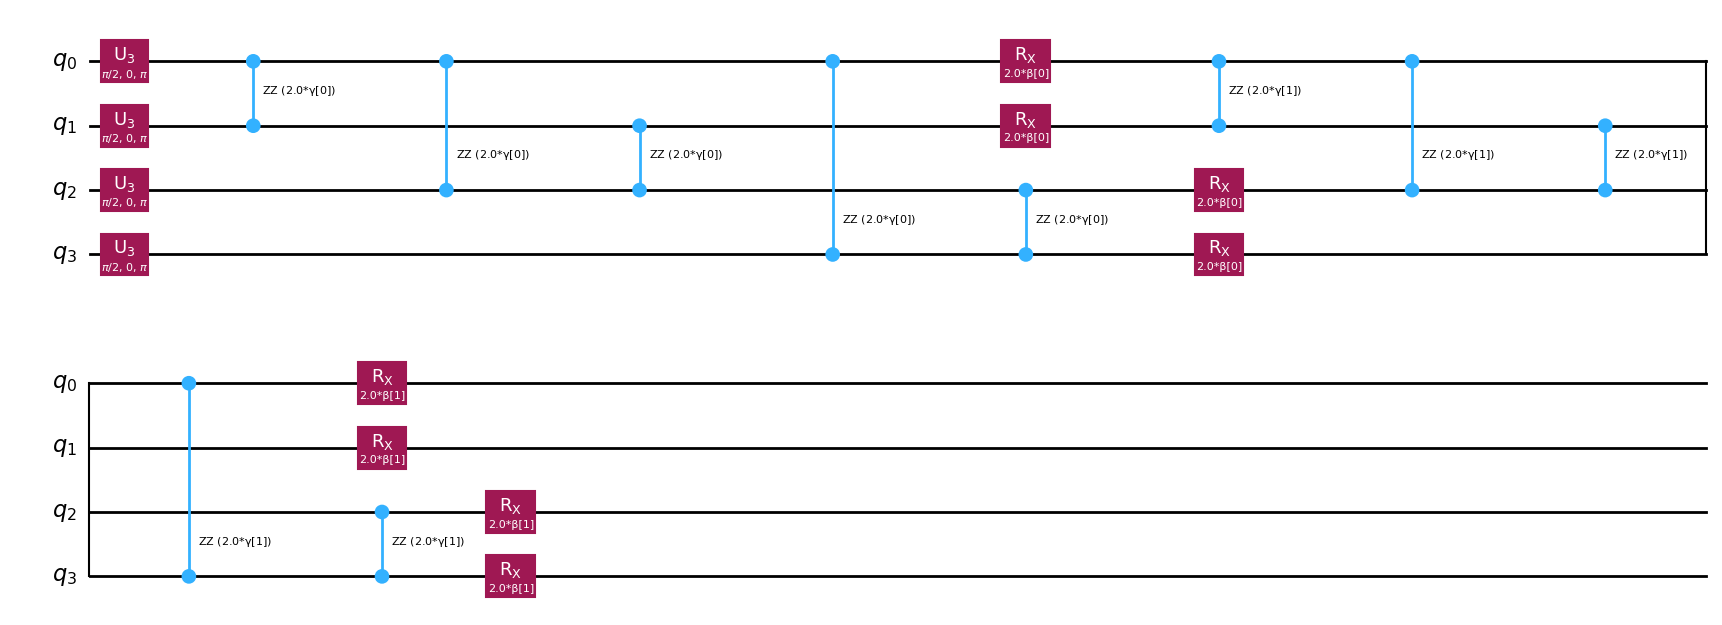

In [18]:
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

hamiltonian = SparsePauliOp.from_list([
    ("IIZZ", 1), ("IZIZ", 1), ("IZZI", 1), ("ZIIZ", 1), ("ZZII", 1)
])

ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl", style="iqp")

In [19]:
# Sum the weights, and divide by 2

offset = - sum(edge[2] for edge in edges) / 2
print(f"""Offset: {offset}""")

Offset: -2.5


In [20]:
def cost_func(params, ansatz, hamiltonian, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result().values[0]
    return cost

In [21]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Estimator, Session

service = QiskitRuntimeService(channel='ibm_quantum', token=token)
backend = service.get_backend("ibmq_qasm_simulator")

session = Session(backend=backend)

estimator = Estimator(session=session)

In [22]:
import numpy as np

x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)

In [23]:
cost = cost_func(x0, ansatz, hamiltonian, estimator)
session.close()
cost

0.024500000000000008

## Measurement Strategy: Speed vs Accuracy

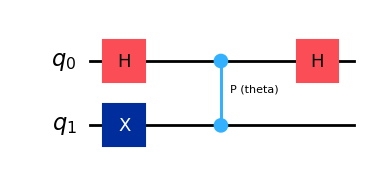

In [2]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

theta = Parameter("theta")

qc = QuantumCircuit(2)
qc.x(1)
qc.h(0)
qc.cp(theta, 0, 1)
qc.h(0)
observables = SparsePauliOp.from_list([("ZZ", 1)])

qc.draw("mpl", style="iqp")

In [3]:
## Setup phases
import numpy as np

phases = np.linspace(0, 2 * np.pi, 50)

# phases need to be expressed as a list of lists in order to work
individual_phases = [[phase] for phase in phases]

In [4]:
## Create noise model
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime import Options
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

# Make a noise model
fake_backend = FakeSherbrooke()
noise_model = NoiseModel.from_backend(fake_backend)

# Set options to include the noise model
options = Options()
options.simulator.set_backend(fake_backend)

In [5]:
from qiskit_ibm_runtime import Session, QiskitRuntimeService, Estimator

# Add your token below
service = QiskitRuntimeService(channel="ibm_quantum", token=token)

noisy_exp_values = []
exp_values_with_em_es = []

with Session(service=service, backend="ibmq_qasm_simulator") as session:
    # generate noisy results
    options.optimization_level = 0
    options.resilience_level = 0

    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    noisy_exp_values = result.values

    options.optimization_level = 3
    options.resilience_level = 2

    # leverage mitigation and suppression
    estimator = Estimator(options=options)
    job = estimator.run(
        circuits=[qc] * len(phases),
        parameter_values=individual_phases,
        observables=[observables] * len(phases),
        shots=1000,
    )
    result = job.result()
    exp_values_with_em_es = result.values

    session.close()

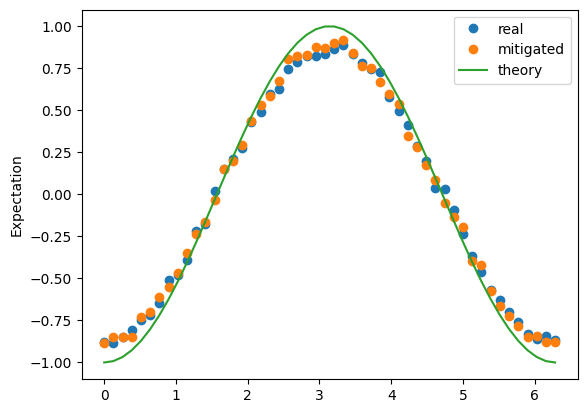

In [6]:
import matplotlib.pyplot as plt

plt.plot(phases, noisy_exp_values, "o", label="real")
plt.plot(phases, exp_values_with_em_es, "o", label="mitigated")
plt.plot(phases, 2 * np.sin(phases / 2) ** 2 - 1, label="theory")
plt.ylabel("Expectation")
plt.legend()
plt.show()